# Table of Content

<a name="outline"></a>

## Setup

- [A](#seca) External Imports
- [B](#secb) Internal Imports
- [C](#secd) Configurations and Paths 
- [D](#sece) Patient Interface and Train/Val/Test Partitioning


## Evaluations

- [1](#sec1) Snooping/Selecting Best Models from the Validation Set
- [2](#sec2) Top-20 Detection Accuracy on MIMIC-III (Test Set)
- [3](#sec3) Top-20 Detection Accuracy on MIMIC-IV (Test Set)
- [4](#sec4) Relative AUC Performance on MIMIC-III (Test Set)
- [5](#sec5) Relative AUC Performance on MIMIC-IV (Test Set)
- [6](#sec6) Relative AUC Performance From MIMIC-III (Training Set) to MIMIC-IV (All)
- [7](#sec7) Relative AUC Performance From MIMIC-IV (Training Set) to MIMIC-III (All)

<a name="seca"></a>

### A External Imports [^](#outline)

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display
from upsetplot import from_contents, plot, UpSet, from_indicators


<a name="secb"></a>

### B Internal Imports [^](#outline)

In [4]:
HOME = os.environ.get('HOME')

%load_ext autoreload
%autoreload 2

import analysis as A
import common as C



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/asem/GP/ICENODE/icenode-env/lib/python3.8/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '


<a name="secc"></a>

### C Configurations and Paths [^](#outline)

In [5]:
mimic_dir = {
    'M3': f'{HOME}/GP/ehr-data/mimic3-transforms',
    'M4': f'{HOME}/GP/ehr-data/mimic4-transforms'
}

train_dir = {
    'GM3': f'{HOME}/GP/ehr-data/icenode-m3-exp/train_config_v0.2.25_G_M3',
    'M3': f'{HOME}/GP/ehr-data/icenode-m3-exp/train_config_v0.2.25_M3',
    'M4': f'{HOME}/GP/ehr-data/icenode-m4-exp/train_config_v0.2.25_M4',
    'GM4': f'{HOME}/GP/ehr-data/icenode-m4-exp/train_config_v0.2.25_G_M4'
}

model_dir = {
    'ICE-NODE': 'icenode_2lr',
    'ICE-NODE_UNIFORM': 'icenode_uniform2lr',
    'GRU': 'gru',
    'RETAIN': 'retain'
}


clfs = list(model_dir.keys())

relative_auc_config = {
    'pvalue': 0.01, 
    'min_auc': 0.9
}

plt.rcParams["font.family"] = "Loma"#, "serif"


In [6]:
output_dir = 'artefacts'
Path(output_dir).mkdir(parents=True, exist_ok=True)

<a name="secd"></a>

### D Patient Interface and Train/Val/Test Patitioning [^](#outline)

In [7]:
m4_interface = C.create_patient_interface(mimic_dir['M4'], 'M4')
m3_interface = C.create_patient_interface(mimic_dir['M3'], 'M3')

m4_train_ids, m4_valid_ids, m4_test_ids = m4_interface.random_splits(split1=0.7, split2=0.85, random_seed=42)
m3_train_ids, m3_valid_ids, m3_test_ids = m3_interface.random_splits(split1=0.7, split2=0.85, random_seed=42)


In [8]:
m4_percentiles = m4_interface.dx_flatccs_by_percentiles(20)
m3_percentiles = m3_interface.dx_flatccs_by_percentiles(20)

m4_train_percentiles = m4_interface.dx_flatccs_by_percentiles(20, m4_train_ids)
m3_train_percentiles = m3_interface.dx_flatccs_by_percentiles(20, m3_train_ids)

<a name="sec1"></a>

## 1 Snooping/Selecting Best Models from the Validation Set [^](#outline)

In [9]:
# Classifiers with Linear Embeddings
clfs = (
    'ICE-NODE', 
    'ICE-NODE_UNIFORM',
    'GRU',
    'RETAIN'
)


# Classifiers with GRAM Embeddings
clfsG = (
    'ICE-NODE', 
    'ICE-NODE_UNIFORM',
    'GRU'
)

In [10]:
m4_traces = A.performance_traces(data_tag='M4', 
                                 clfs=clfs, 
                                 train_dir=train_dir, 
                                 model_dir=model_dir)
gm4_traces =  A.performance_traces(data_tag='GM4', 
                                   clfs=clfsG, 
                                   train_dir=train_dir, 
                                   model_dir=model_dir)

gm3_traces =  A.performance_traces(data_tag='GM3', 
                                   clfs=clfsG, 
                                   train_dir=train_dir, 
                                   model_dir=model_dir)
m3_traces = A.performance_traces(data_tag='M3', 
                                 clfs=clfs, 
                                 train_dir=train_dir, 
                                 model_dir=model_dir)

plt_ctx = lambda : sns.plotting_context("poster", font_scale=2, rc={"lines.linewidth": 2.5,  'grid.linestyle': '--'})


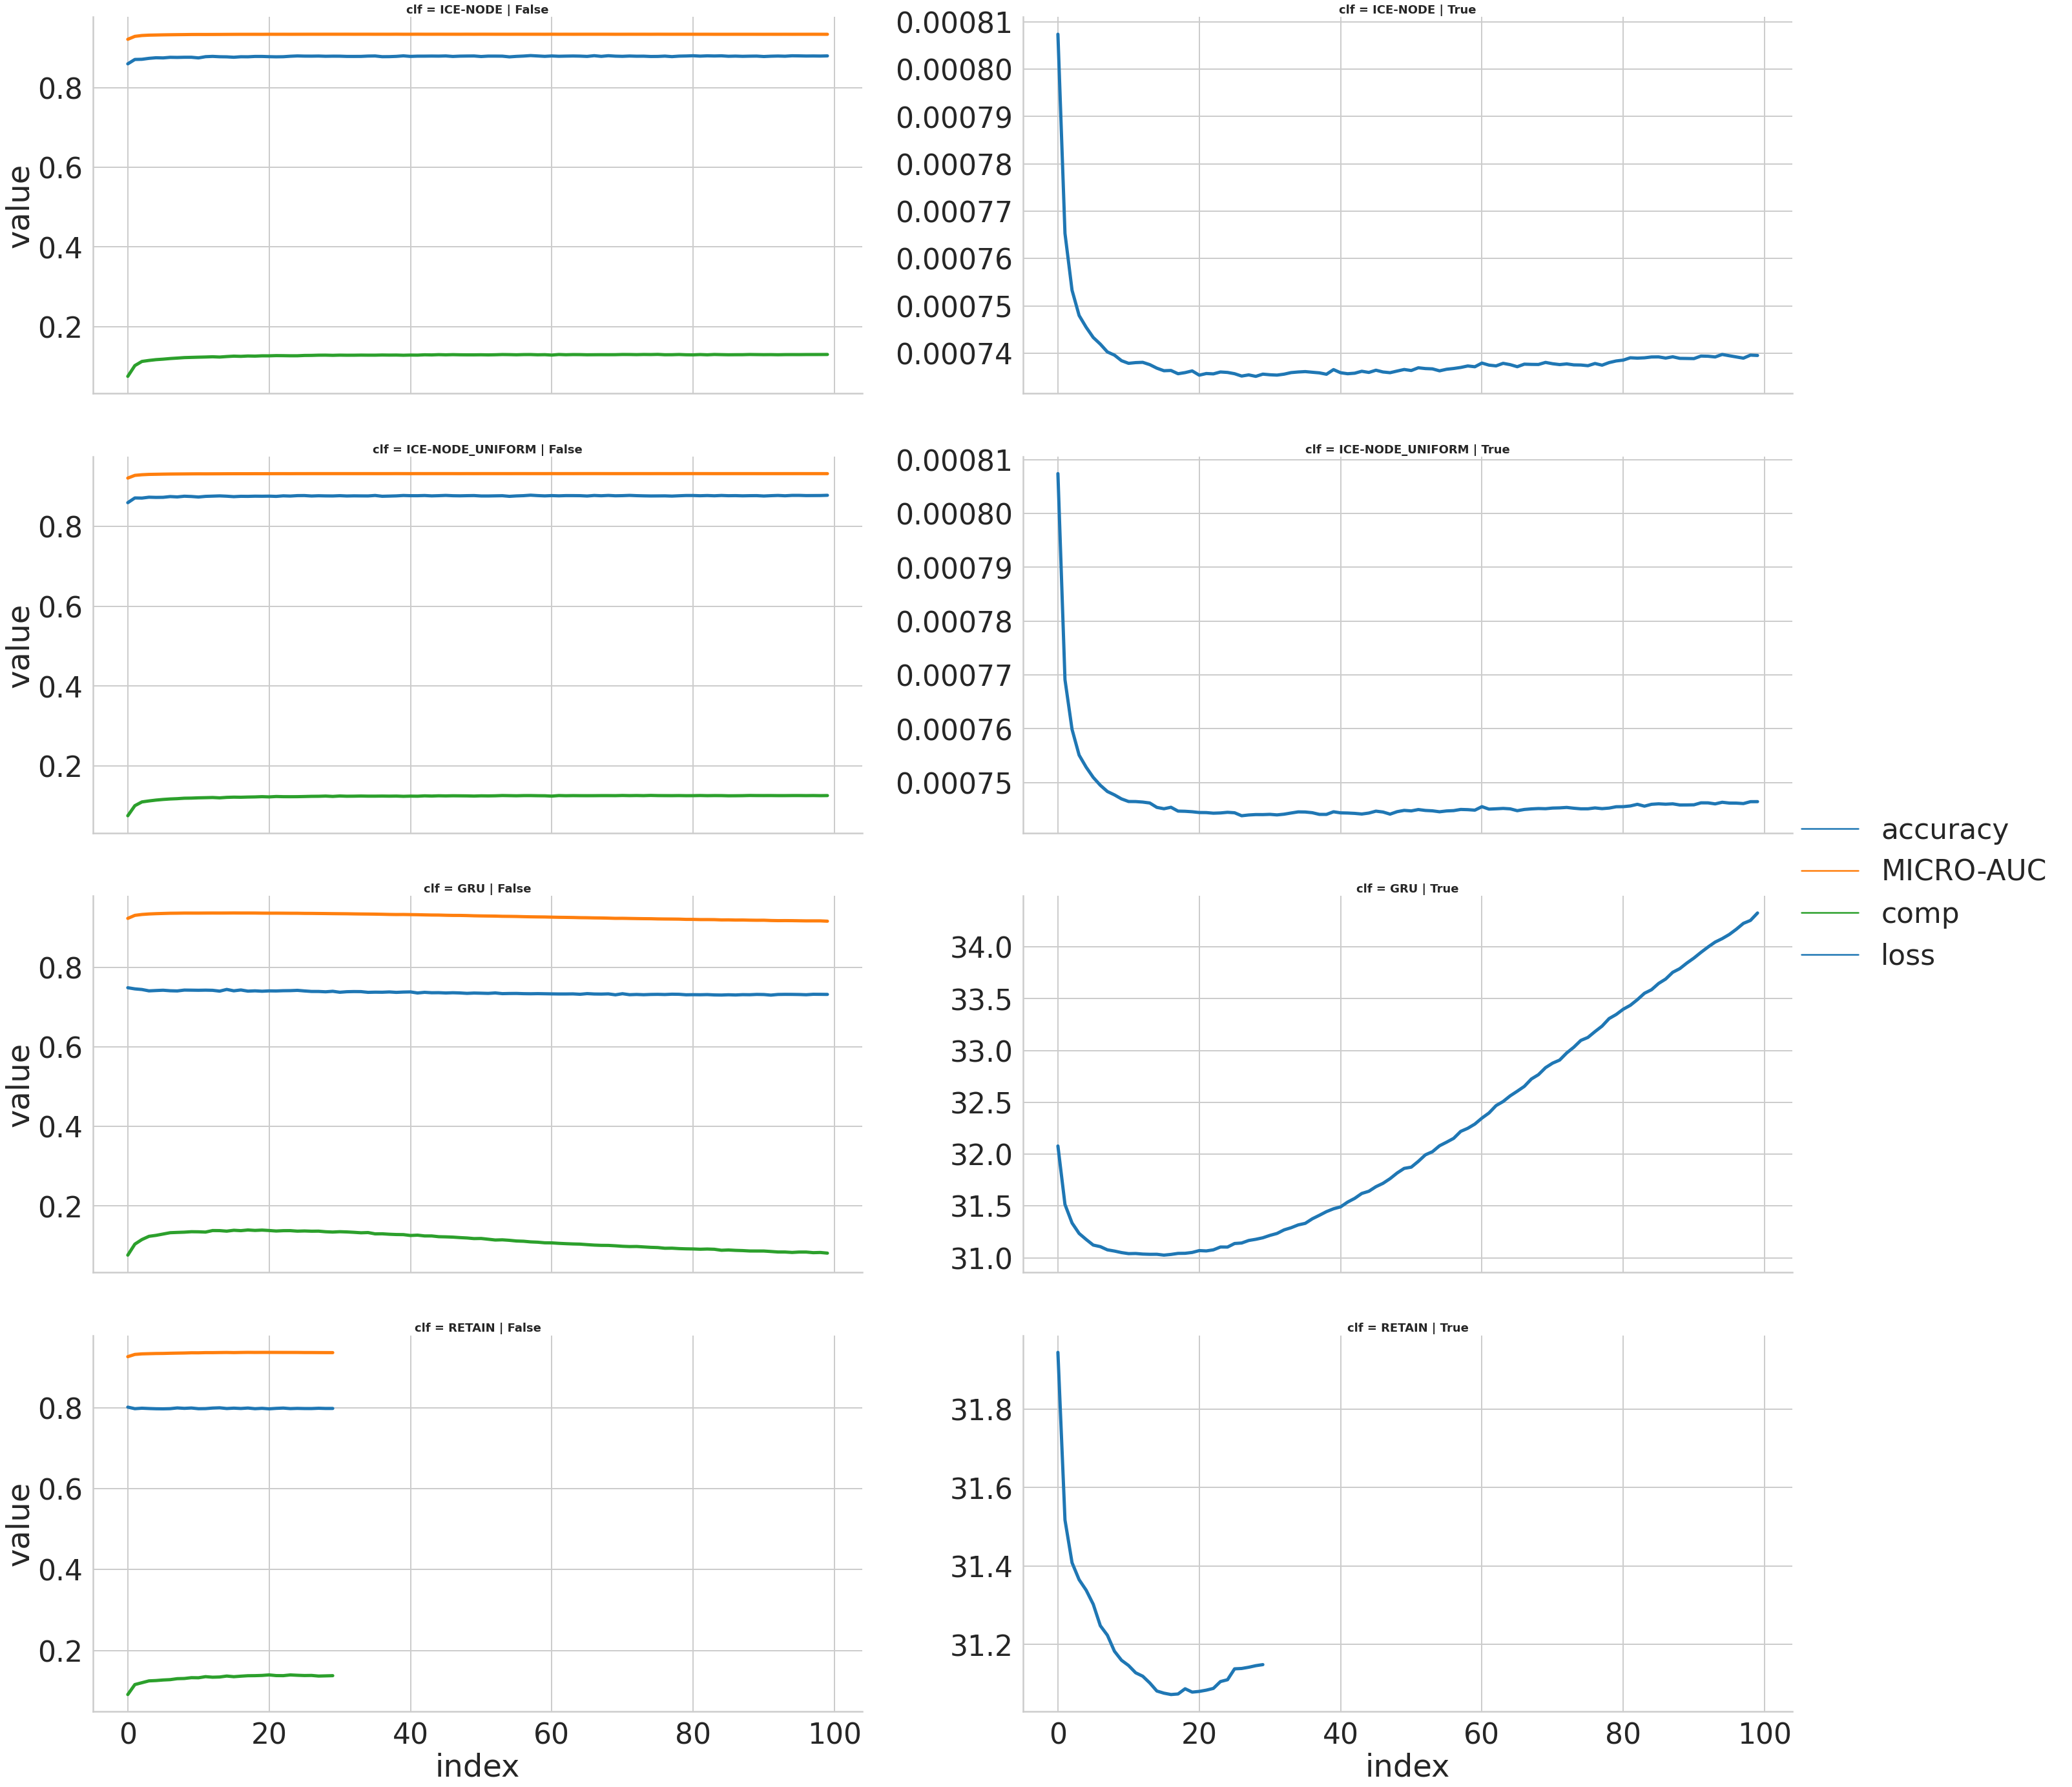

In [11]:
with sns.axes_style("whitegrid"), plt_ctx():
    g = sns.FacetGrid(data=m4_traces, row='clf', col='loss',  height=10, aspect=2, sharey=False, despine=True)
    g.map_dataframe(sns.lineplot, 'index', 'value', 'metric', **dict(linewidth=5))
    g.set_titles(col_template="{col_name}", fontweight='bold', size=18)
    g.add_legend()

    current_figure = plt.gcf()
    current_figure.savefig(f"{output_dir}/M4_performance_trace.pdf")

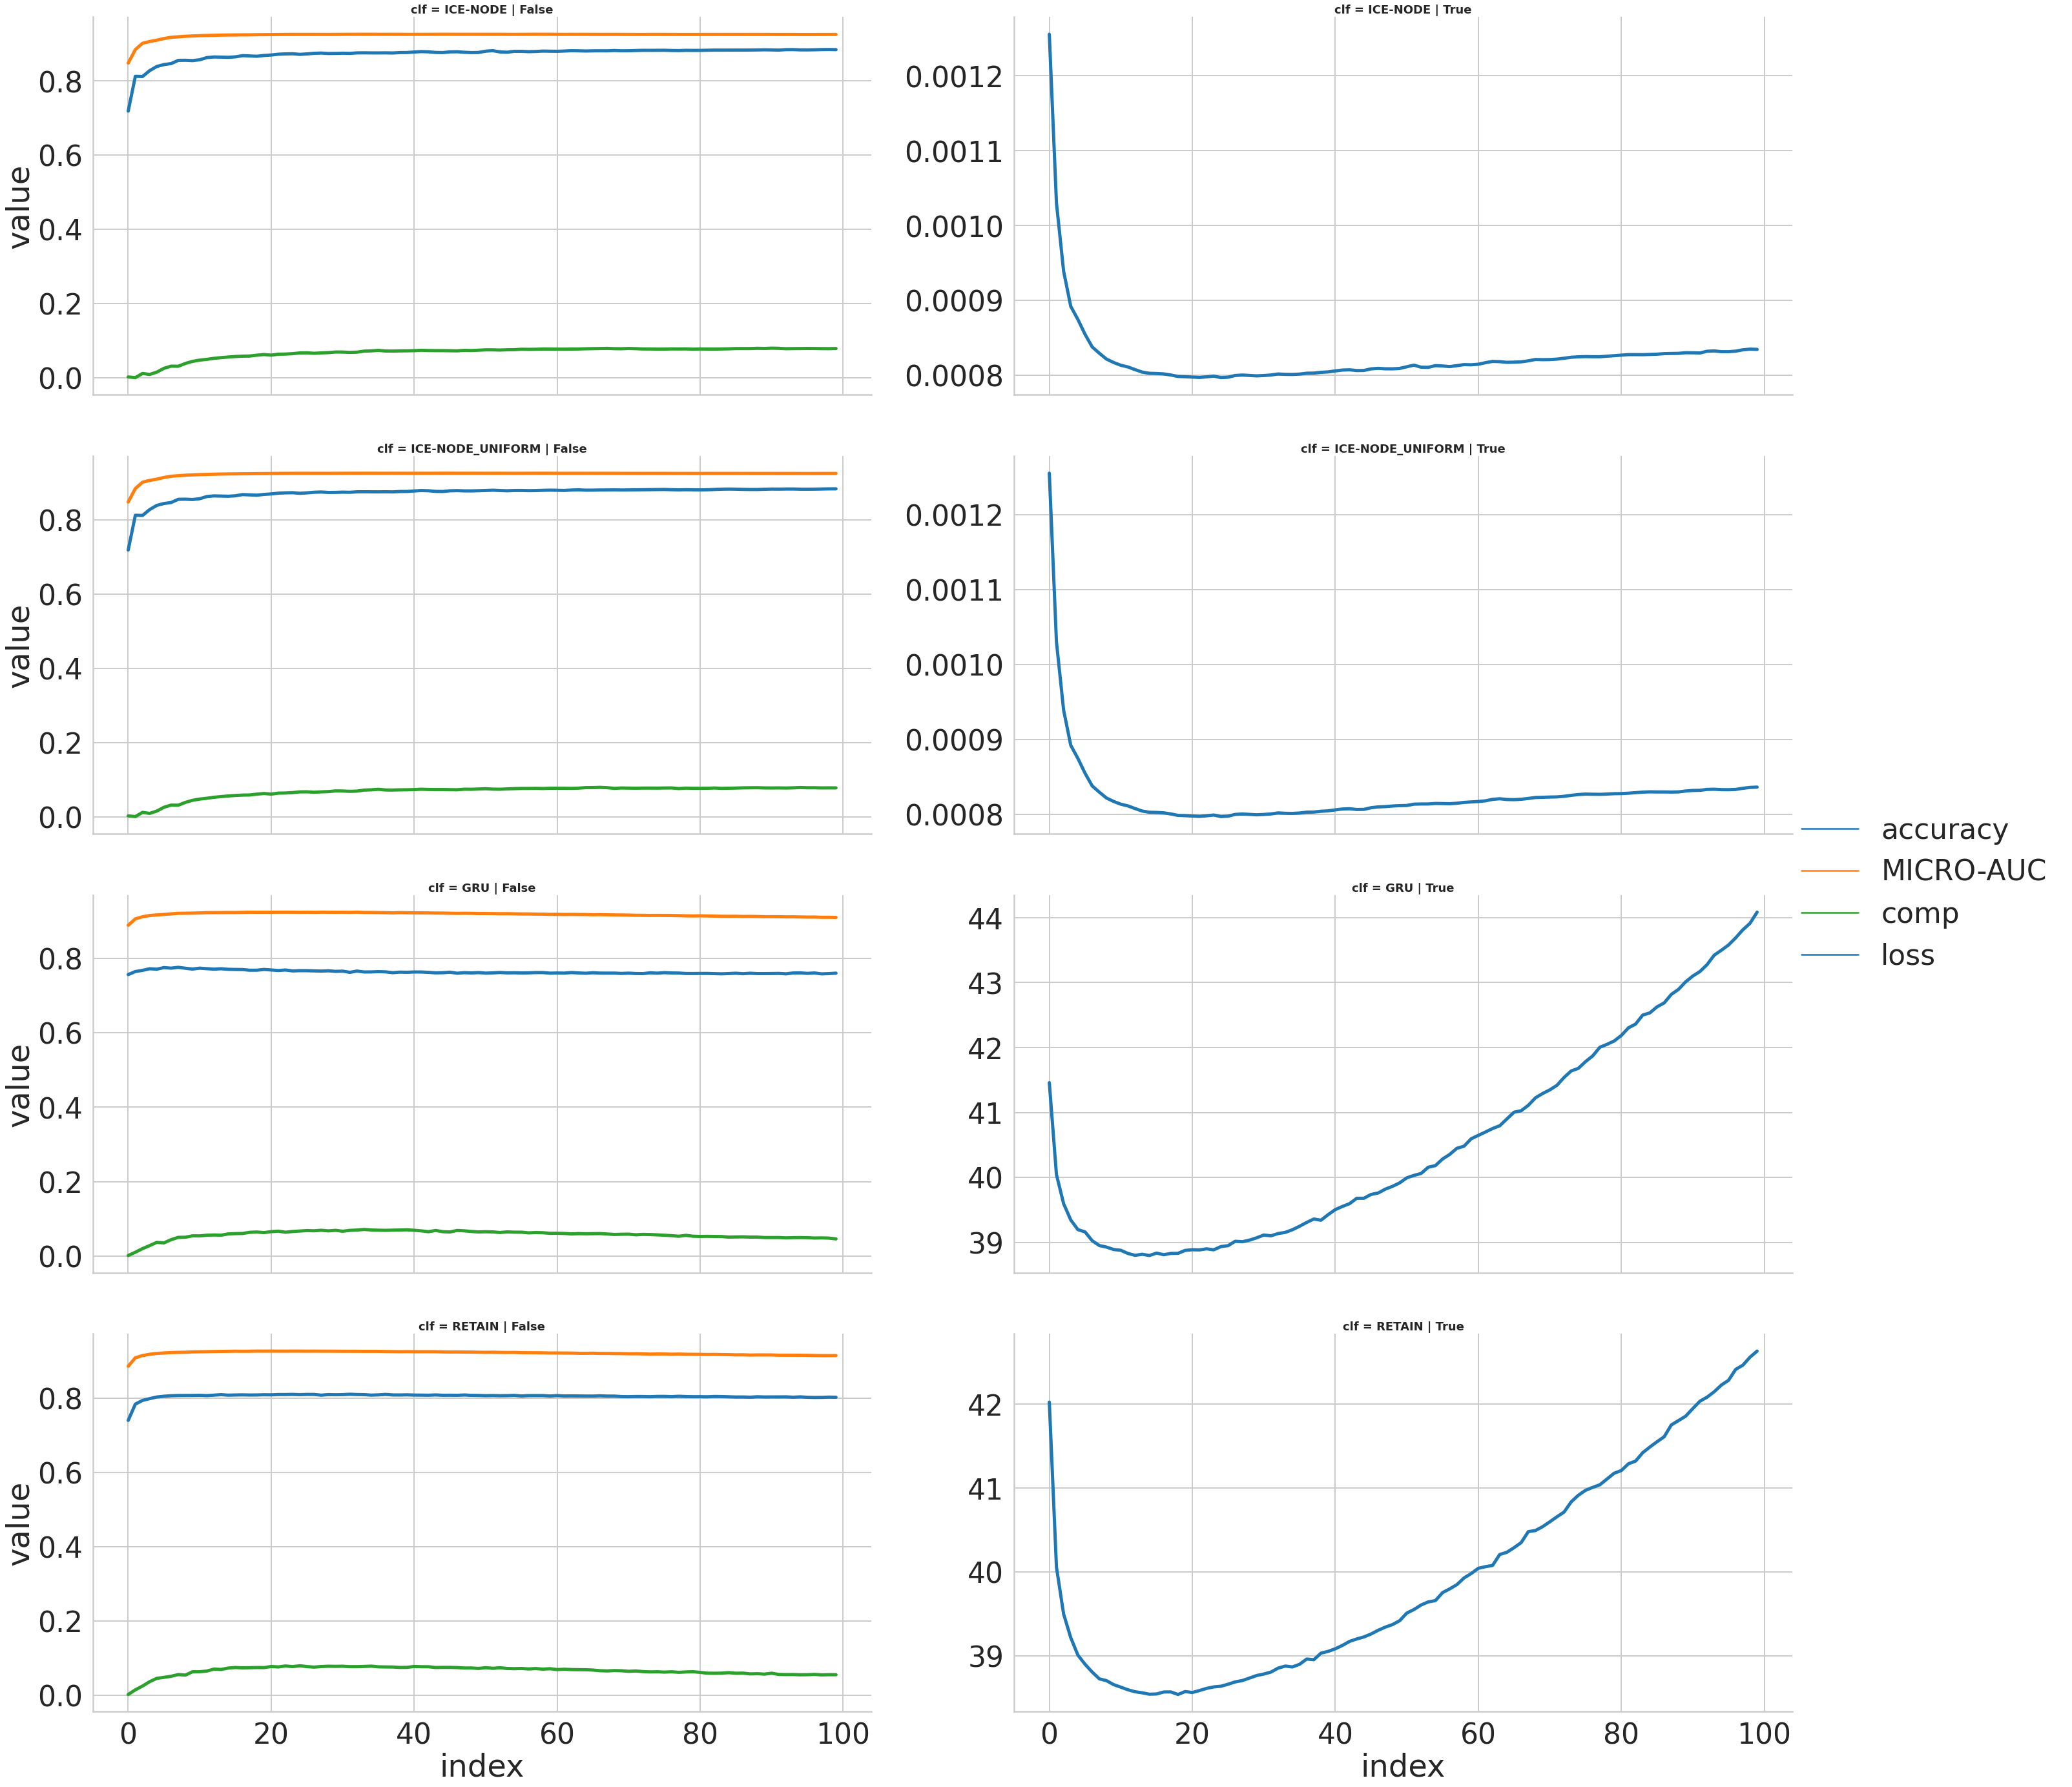

In [12]:
with sns.axes_style("whitegrid"), plt_ctx():
    g = sns.FacetGrid(data=m3_traces, row='clf', col='loss',  height=10, aspect=2, sharey=False, despine=True)
    g.map_dataframe(sns.lineplot, 'index', 'value', 'metric', **dict(linewidth=5))
    g.set_titles(col_template="{col_name}", fontweight='bold', size=18)
    g.add_legend()
    
    current_figure = plt.gcf()
    current_figure.savefig(f"{output_dir}/M3_performance_trace.pdf")

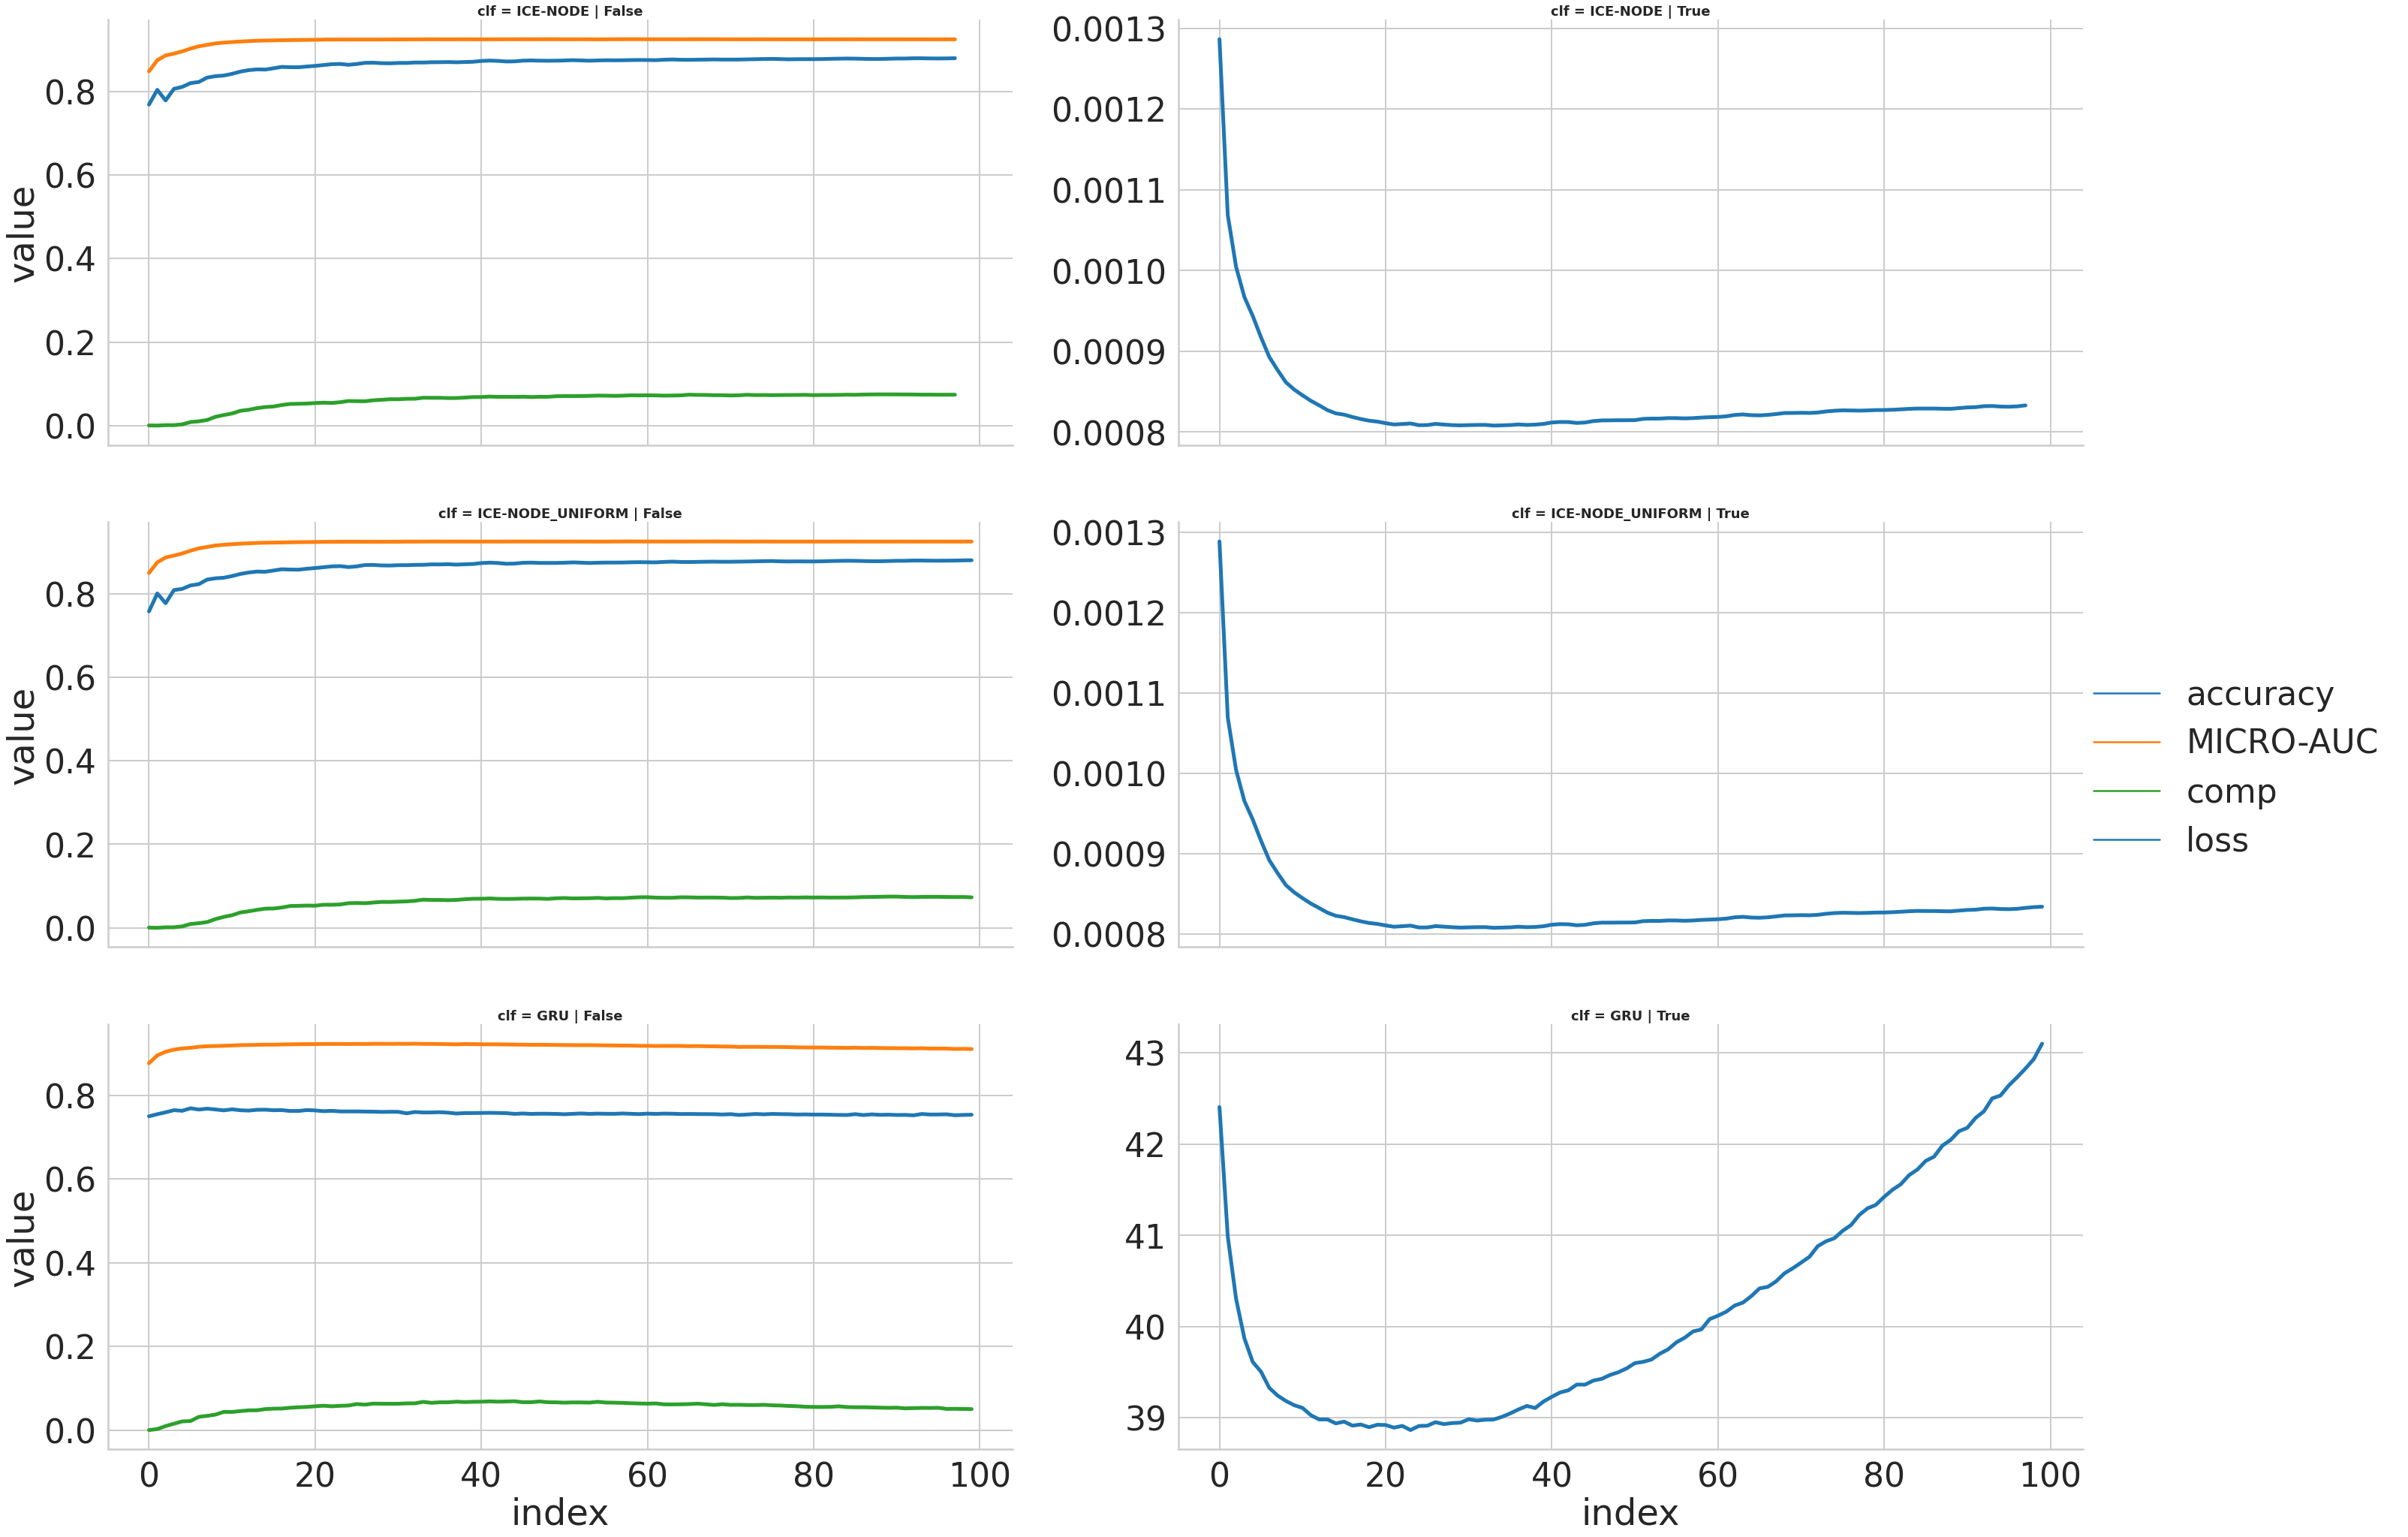

In [13]:
with sns.axes_style("whitegrid"), plt_ctx():
    g = sns.FacetGrid(data=gm3_traces, row='clf', col='loss',  height=10, aspect=2, sharey=False, despine=True)
    g.map_dataframe(sns.lineplot, 'index', 'value', 'metric', **dict(linewidth=5))
    g.set_titles(col_template="{col_name}", fontweight='bold', size=18)
    g.add_legend()
    
    current_figure = plt.gcf()
    current_figure.savefig(f"{output_dir}/GM3_performance_trace.pdf")

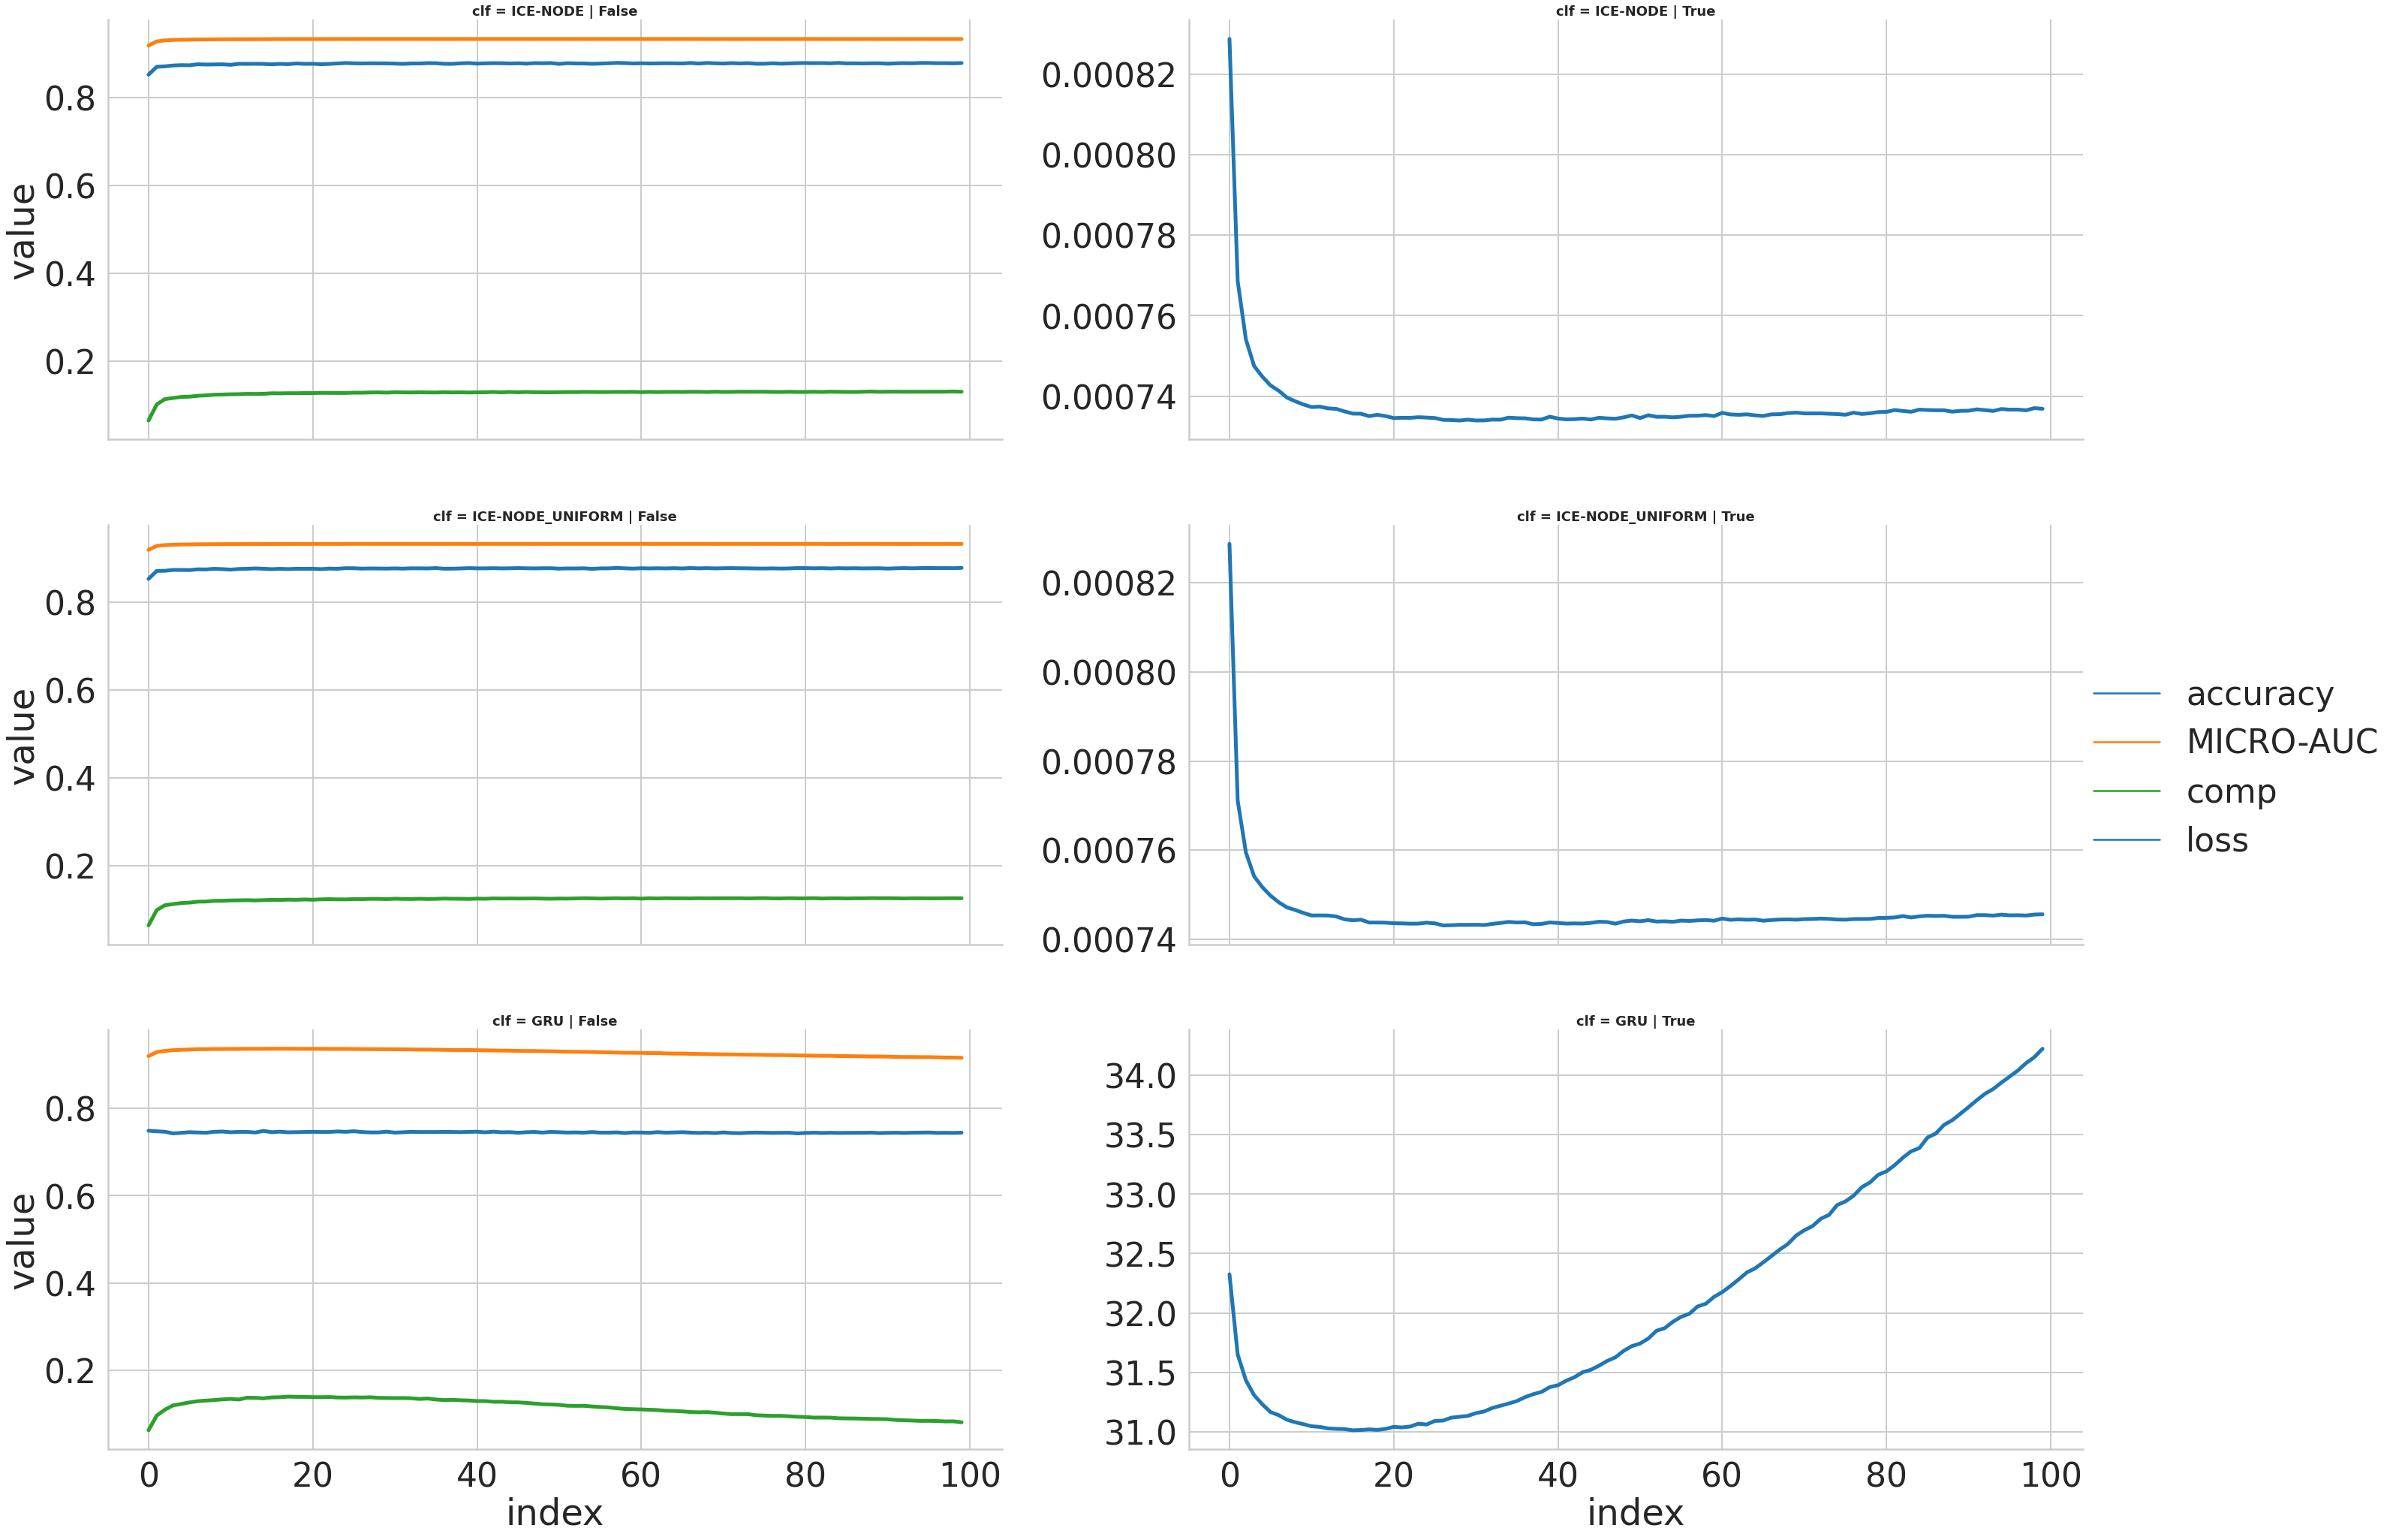

In [14]:
with sns.axes_style("whitegrid"), plt_ctx():
    g = sns.FacetGrid(data=gm4_traces, row='clf', col='loss',  height=10, aspect=2, sharey=False, despine=True)
    g.map_dataframe(sns.lineplot, 'index', 'value', 'metric', **dict(linewidth=5))
    g.set_titles(col_template="{col_name}", fontweight='bold', size=18)
    g.add_legend()
    
    current_figure = plt.gcf()
    current_figure.savefig(f"{output_dir}/GM4_performance_trace.pdf")

In [15]:
print('> Models trained on MIMIC-III')
m3_uAUC = A.get_trained_models(clfs=clfs, train_dir=train_dir, model_dir=model_dir, data_tag='M3', 
                               criterion='MICRO-AUC',  comp=max)
display(m3_uAUC['summary'])

print('> Models trained on MIMIC-IV')
m4_uAUC = A.get_trained_models(clfs=clfs, train_dir=train_dir, model_dir=model_dir, data_tag='M4', 
                               criterion='MICRO-AUC',  comp=max)
display(m4_uAUC['summary'])


print('> Models (GRAM) trained on MIMIC-III')
gm3_uAUC = A.get_trained_models(clfs=clfsG, train_dir=train_dir, model_dir=model_dir, data_tag='GM3',  
                                criterion='MICRO-AUC', comp=max)
display(gm3_uAUC['summary'])

print('> Models (GRAM) trained on MIMIC-IV')
gm4_uAUC = A.get_trained_models(clfs=clfsG, train_dir=train_dir, model_dir=model_dir, data_tag='GM4', 
                                criterion='MICRO-AUC', comp=max)
display(gm4_uAUC['summary'])


> Models trained on MIMIC-III


,Clf,Best_i,MICRO-AUC
0,ICE-NODE,57,0.925790
1,ICE-NODE_UNIFORM,44,0.925757
2,GRU,32,0.923570
3,RETAIN,20,0.927307


> Models trained on MIMIC-IV


,Clf,Best_i,MICRO-AUC
0,ICE-NODE,38,0.933961
1,ICE-NODE_UNIFORM,66,0.932462
2,GRU,15,0.936528
3,RETAIN,17,0.936482


> Models (GRAM) trained on MIMIC-III


,Clf,Best_i,MICRO-AUC
0,ICE-NODE,58,0.924722
1,ICE-NODE_UNIFORM,58,0.924760
2,GRU,32,0.923149


> Models (GRAM) trained on MIMIC-IV


,Clf,Best_i,MICRO-AUC
0,ICE-NODE,41,0.934028
1,ICE-NODE_UNIFORM,29,0.932499
2,GRU,17,0.936749


In [16]:
print('> Models trained on MIMIC-III')
m3_loss =  A.get_trained_models(clfs=clfs, train_dir=train_dir, model_dir=model_dir, data_tag='M3', 
                                criterion='loss', comp=min)
display(m3_loss['summary'])

print('> Models trained on MIMIC-IV')
m4_loss = A.get_trained_models(clfs=clfs, train_dir=train_dir, model_dir=model_dir, data_tag='M4',
                             criterion='loss',  comp=min)
display(m4_loss['summary'])

print('> Models (GRAM) trained on MIMIC-III')
gm3_loss = A.get_trained_models(clfs=clfsG, train_dir=train_dir, model_dir=model_dir, data_tag='GM3',
                                criterion='loss', comp=min)
display(gm3_loss['summary'])

print('> Models (GRAM) trained on MIMIC-IV')
gm4_loss = A.get_trained_models(clfs=clfsG, train_dir=train_dir, model_dir=model_dir, data_tag='GM4',
                                criterion='loss', comp=min)
display(gm4_loss['summary'])


> Models trained on MIMIC-III


,Clf,Best_i,loss
0,ICE-NODE,24,0.000797
1,ICE-NODE_UNIFORM,24,0.000797
2,GRU,14,38.797390
3,RETAIN,18,38.536705


> Models trained on MIMIC-IV


,Clf,Best_i,loss
0,ICE-NODE,28,0.000735
1,ICE-NODE_UNIFORM,26,0.000744
2,GRU,15,31.025291
3,RETAIN,16,31.072317


> Models (GRAM) trained on MIMIC-III


,Clf,Best_i,loss
0,ICE-NODE,33,0.000808
1,ICE-NODE_UNIFORM,33,0.000808
2,GRU,23,38.865055


> Models (GRAM) trained on MIMIC-IV


,Clf,Best_i,loss
0,ICE-NODE,28,0.000734
1,ICE-NODE_UNIFORM,26,0.000743
2,GRU,15,31.012642


In [17]:
def combine_acc(row):
    return 1 / (1 / row.loc[list(f'ACC-P{i}' for i in range(5))]).sum()

print('> Models trained on MIMIC-III')
m3_comb = A.get_trained_models(clfs=clfs, train_dir=train_dir, model_dir=model_dir, data_tag='M3', 
                             criterion=combine_acc, comp=max)
display(m3_comb['summary'])


print('> Models trained on MIMIC-IV')
m4_comb = A.get_trained_models(clfs=clfs, train_dir=train_dir, model_dir=model_dir, data_tag='M4', 
                             criterion=combine_acc, comp=max)
display(m4_comb['summary'])


print('> Models (GRAM) trained on MIMIC-III')
gm3_comb = A.get_trained_models(clfs=clfsG, train_dir=train_dir, model_dir=model_dir, data_tag='GM3', 
                              criterion=combine_acc, comp=max)
display(gm3_comb['summary'])


print('> Models (GRAM) trained on MIMIC-IV')
gm4_comb = A.get_trained_models(clfs=clfsG, train_dir=train_dir, model_dir=model_dir, data_tag='GM4', 
                               criterion=combine_acc, comp=max)
display(gm4_comb['summary'])



> Models trained on MIMIC-III


,Clf,Best_i,<function combine_acc at 0x7f62f51bd820>
0,ICE-NODE,90,0.109711
1,ICE-NODE_UNIFORM,94,0.109345
2,GRU,39,0.107409
3,RETAIN,40,0.109896


> Models trained on MIMIC-IV


,Clf,Best_i,<function combine_acc at 0x7f62f51bd820>
0,ICE-NODE,88,0.126702
1,ICE-NODE_UNIFORM,88,0.125716
2,GRU,19,0.127814
3,RETAIN,23,0.127869


> Models (GRAM) trained on MIMIC-III


,Clf,Best_i,<function combine_acc at 0x7f62f51bd820>
0,ICE-NODE,88,0.107542
1,ICE-NODE_UNIFORM,90,0.107439
2,GRU,44,0.106158


> Models (GRAM) trained on MIMIC-IV


,Clf,Best_i,<function combine_acc at 0x7f62f51bd820>
0,ICE-NODE,88,0.126651
1,ICE-NODE_UNIFORM,88,0.125798
2,GRU,27,0.127750


In [18]:

m3_models_uAUC = C.get_models(clfs, m3_uAUC["config"], m3_uAUC["params"], m3_interface)
gm3_models_uAUC = C.get_models(clfsG, gm3_uAUC["config"], gm3_uAUC["params"], m3_interface)

m4_models_uAUC = C.get_models(clfs, m4_uAUC["config"], m4_uAUC["params"], m4_interface)
gm4_models_uAUC = C.get_models(clfsG, gm4_uAUC["config"], gm4_uAUC["params"], m4_interface)


In [19]:
m3_models_loss = C.get_models(clfs, m3_loss["config"], m3_loss["params"], m3_interface)
gm3_models_loss = C.get_models(clfsG, gm3_loss["config"], gm3_loss["params"], m3_interface)

m4_models_loss = C.get_models(clfs, m4_loss["config"], m4_loss["params"], m4_interface)
gm4_models_loss = C.get_models(clfsG, gm4_loss["config"], gm4_loss["params"], m4_interface)

In [20]:
m3_models_comb = C.get_models(clfs, m3_comb["config"], m3_comb["params"], m3_interface)
gm3_models_comb = C.get_models(clfsG, gm3_comb["config"], gm3_comb["params"], m3_interface)

m4_models_comb = C.get_models(clfs, m4_comb["config"], m4_comb["params"], m4_interface)
gm4_models_comb = C.get_models(clfsG, gm4_comb["config"], gm4_comb["params"], m4_interface)

### Snooping on MIMIC-III Validation Set

In [21]:
m3_val_res_uAUC = {clf: C.eval_(model, m3_valid_ids) for clf, model in m3_models_uAUC.items()} 
m3_val_res_comb = {clf: C.eval_(model, m3_valid_ids) for clf, model in m3_models_comb.items()} 
m3_val_res_loss = {clf: C.eval_(model, m3_valid_ids) for clf, model in m3_models_loss.items()} 

m3_val_res_all = {
    **{f'{clf}_uAUC': res for clf, res in m3_val_res_uAUC.items()},
    **{f'{clf}_comb': res for clf, res in m3_val_res_comb.items()},
    **{f'{clf}_loss': res for clf, res in m3_val_res_loss.items()}
}

In [22]:
m3_val_auctests_all = A.codes_auc_pairwise_tests(m3_val_res_all, fast=True)

 17%|██████████████████████████▎                                                                                                                                    | 40/242 [00:06<00:37,  5.32it/s]WARNING:absl:Indeterminate test


 35%|███████████████████████████████████████████████████████▊                                                                                                       | 85/242 [00:13<00:10, 14.38it/s]WARNING:absl:Indeterminate test


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 156/242 [00:21<00:16,  5.24it/s]WARNING:absl:Indeterminate test


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 203/242 [00:29<00:06,  6.11it/s]WARNING:absl:Indeterminate test


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 242/242 [00:35<00:00,  6.81it/s]


In [49]:

selected_clfs = tuple(sorted(m3_val_res_all.keys()))
content_set, indicator_df, data, common_codes, dichotomous_codes = A.relative_performance_upset(m3_val_auctests_all, selected_clfs, 
                                                                                              **relative_auc_config)
upset_format = from_indicators(indicator_df, data=data)

upset_object.plot()
plt.show()

46 codes predicted an AUC higher than 0.9 by at least one model.
3       1
12      1
13      1
22      3
43      1
51      1
57      1
59      1
61      1
66      1
72      1
73      1
80      1
94     11
95      1
96      4
97      1
99      1
100     2
107     1
111     1
117     1
118     1
122     1
123     1
124     1
125     1
127     1
128     1
130     1
136     1
137     1
141     1
143     1
146     1
152     1
154     1
156     1
157     1
158     1
159     1
163     1
164     1
165     1
166     1
173     1
dtype: int64
0 codes predicted an AUC higher than 0.9 by at least one model, with valid tests.


ValueError: Must pass non-zero number of levels/codes

### Snooping on MIMIC-IV Validation Set

In [23]:
m4_val_res_uAUC = {clf: C.eval_(model, m4_valid_ids) for clf, model in m4_models_uAUC.items()} 
m4_val_res_comb = {clf: C.eval_(model, m4_valid_ids) for clf, model in m4_models_comb.items()} 
m4_val_res_loss = {clf: C.eval_(model, m4_valid_ids) for clf, model in m4_models_loss.items()} 

m4_val_res_all = {
    **{f'{clf}_uAUC': res for clf, res in m4_val_res_uAUC.items()},
    **{f'{clf}_comb': res for clf, res in m4_val_res_comb.items()},
    **{f'{clf}_loss': res for clf, res in m4_val_res_loss.items()}
}

In [24]:
m4_val_auctests_all = A.codes_auc_pairwise_tests(m4_val_res_all, fast=True)

 14%|██████████████████████▉                                                                                                                                        | 35/242 [02:50<17:13,  4.99s/it]WARNING:absl:Indeterminate test


 29%|█████████████████████████████████████████████▉                                                                                                                 | 70/242 [05:44<14:16,  4.98s/it]WARNING:absl:Indeterminate test


 43%|████████████████████████████████████████████████████████████████████▌                                                                                         | 105/242 [08:38<11:21,  4.97s/it]WARNING:absl:Indeterminate test


 60%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                | 144/242 [11:33<06:56,  4.25s/it]WARNING:absl:Indeterminate test


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 179/242 [14:28<05:14,  4.99s/it]WARNING:absl:Indeterminate test


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 214/242 [17:22<02:19,  4.98s/it]WARNING:absl:Indeterminate test


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 242/242 [19:42<00:00,  4.89s/it]


In [ ]:
selected_clfs = tuple(sorted(m4_val_res_all.keys()))
content_set, indicator_df, data, common_codes, dichotomous_codes = A.relative_performance_upset(m4_val_auctests_all,
                                                                                              selected_clfs, 
                                                                                              **relative_auc_config)
upset_format = from_indicators(indicator_df, data=data)
upset_object = UpSet(upset_format, subset_size='count', show_counts=True)

upset_object.plot()
plt.show()

### Snooping Conclusion

In the cells above, we evaluate the model competency by the number of codes
predicted competently compared to the other models.
It is realized that for `GRU`, `RETAIN`, and `ICENODE_UNIFORM`, the competency is maximized by picking the
model with minimum validation loss throughout the training iterations.
However, `ICENODE` competency is maximized by picking the model with maximum average validation AUC throughout the training iterations. Therefore, subsequent evaluations will consider only the most competent models on the validation set, as we select in the next cell.

In [42]:
m4_config = {}
m4_params = {}
m4_eval = {}

m3_config = {}
m3_params = {}
m3_eval = {}

gm4_config = {}
gm4_params = {}
gm4_eval = {}

gm3_config = {}
gm3_params = {}
gm3_eval = {}

selection_dicts = (m4_config, m4_params, m4_eval, 
                   m3_config, m3_params, m3_eval, 
                   gm4_config, gm4_params, gm4_eval,
                   gm3_config, gm3_params, gm3_eval)

uAUC_dicts = (m4_config_uAUC, m4_params_uAUC, m4_df_uAUC,
              m3_config_uAUC, m3_params_uAUC, m3_df_uAUC,
              m4_config_uAUCG, m4_params_uAUCG, m4_df_uAUCG,
              m3_config_uAUCG, m3_params_uAUCG, m3_df_uAUCG)

comb_dicts = (m4_config_comb, m4_params_comb, m4_df_comb,
              m3_config_comb, m3_params_comb, m3_df_comb,
              m4_config_combG, m4_params_combG, m4_df_combG,
              m3_config_combG, m3_params_combG, m3_df_combG)


loss_dicts = (m4_config_loss, m4_params_loss, m4_df_loss,
              m3_config_loss, m3_params_loss, m3_df_loss,
              m4_config_lossG, m4_params_lossG, m4_df_lossG,
              m3_config_lossG, m3_params_lossG, m3_df_lossG)

for clf in ('GRU', 'RETAIN', 'ICE-NODE', 'ICE-NODE_UNIFORM'):
#     best_dicts = maxauc_dicts
#     if clf == 'ICE-NODE':

#     else:
#     best_dicts = minloss_dicts
        
    for dict_a, dict_b in zip(selection_dicts, uAUC_dicts):
        if clf in dict_b:
            dict_a[clf] = dict_b[clf]

NameError: name 'm4_config_uAUC' is not defined

In [ ]:
def cross_predictor(clf, source_tag, target_tag):
    if '/G' in clf:
        clf = clf.replace('/G', '')
        _params = {'M3': gm3_params[clf], 'M4': gm4_params[clf]}
        _config = {'M3': gm3_config[clf], 'M4': gm4_config[clf]}
    else:
        _params = {'M3': m3_params[clf], 'M4': m4_params[clf]}
        _config = {'M3': m3_config[clf], 'M4': m4_config[clf]}
    _interface = {'M3': m3_interface, 'M4': m4_interface}

    return A.get_model(clf=clf, 
                       config=_config[source_tag], 
                       params=_params[source_tag],
                       interface = _interface[target_tag])


<a name="sec2"></a>

## 2 Top-20 Detection Accuracy on MIMIC-III (Test Set) [^](#outline)

In [ ]:


def styled_df(df):  
    import numpy as np
    pd.set_option('precision', 3)
    def highlight_max(s, props=''):
        return np.where(s == np.nanmax(s.values), props, '')
    
    s_df = df.style
    s_df = s_df.apply(highlight_max, props='bfseries: ;color:white;background-color:darkblue', axis=0)
    texttt = [{'selector': 'th', 'props': 'font-family: monospace;'}]

    latex_str = s_df.to_latex(convert_css=True)
    for clf in df.index.tolist():
        latex_str = latex_str.replace(clf, f'\\texttt{{{clf}}}', 1)
    latex_str = latex_str.replace('_', '\\_')
    return s_df, latex_str

In [ ]:
# Pick the best models results from max_auc and min_loss snapshots on the validation data.



df_acc20_dict = {
    **{clf: m3_eval[clf] for clf in ('ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN')},
    **{f'{clf}/G': gm3_eval[clf] for clf in ('ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU')},
}

df_acc20 = test_eval_table(df_acc20_dict, list(f'ACC-P{i}' for i in range(5)))
df_acc20 = df_acc20.apply(lambda x: round(x, 3))
df_acc20.to_csv(f'acc20_mimic3.csv')

s_df, ltx_s = styled_df(df_acc20)
display(s_df)
print(ltx_s)

<a name="sec3"></a>

## 3 Top-20 Detection Accuracy on MIMIC-IV (Test Set) [^](#outline)

In [ ]:
# Pick the best models results from max_auc and min_loss snapshots on the validation data.
df_acc20 = {
    clf: m4_eval[clf] for clf in ('ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN')
}

df_acc20 = test_eval_table(df_acc20, list(f'ACC-P{i}' for i in range(5)))
df_acc20 = df_acc20.apply(lambda x: round(x, 3))
df_acc20.to_csv(f'acc20_mimic4.csv')

s_df, ltx_s = styled_df(df_acc20)
display(s_df)
print(ltx_s)

<a name="sec4"></a>

## 4 Relative AUC Performance on MIMIC-III (Test Set) [^](#outline)

In [ ]:
m3_clfs =  ('ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN',
           'ICE-NODE/G', 'ICE-NODE_UNIFORM/G', 'GRU/G')
m3_predictors = {clf: cross_predictor(clf, 'M3', 'M3') for clf in m3_clfs}

In [ ]:
test_res_m3 = {clf: eval2_(model, m3_test_ids) for clf, model in m3_predictors.items()} 

In [ ]:
auctests_m3 = codes_auc_pairwise_tests({k: v['diag_detectability'] for k, v in test_res_m3.items()}, fast=True)


In [ ]:
test_cols = [col for col in auctests_m3.columns if col[:2] == 'P0']
auctests_m3.loc[:, test_cols].isnull().max(axis=1).sum()

In [ ]:

upset_clfs = ['ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN']#, 'ICE-NODE/G', 'ICE-NODE_UNIFORM/G', 'GRU/G']
upsetcontents_m3, upsetindicator_m3, data_m3,  _, compete_codesm3 = relative_performance_upset(auctests_m3, 
                                                                                               upset_clfs, 
                                                                                               m3_interface,
                                                                                               m3_train_ids,
                                                                                               **relative_auc_config)

upset_ctx = lambda : sns.plotting_context("paper", font_scale=1.5, rc={"font.family": "Loma", 
                                                                        'axes.labelsize': 'medium',
                                                                       'ytick.labelsize': 'medium'})
with sns.axes_style("darkgrid"), upset_ctx():
    upset_format = from_indicators(upsetindicator_m3, data=data_m3)
    upset_object = UpSet(upset_format, subset_size='count', show_counts=True)
    upset_object.style_subsets(max_subset_size=1,
                               facecolor="red",
                               edgecolor="red", linewidth=3)

#     upset_object.add_catplot(value='Avg. AUC', kind="strip")
#     upset_object.add_catplot(value='#codes (train)', kind="strip")
    g = upset_object.plot()
#     g['extra1'].set_yscale('log')

    current_figure = plt.gcf()
    w, h = 3.5, 3
    wi, hi = current_figure.get_size_inches()
    current_figure.set_size_inches(hi*(w/h), hi)
    current_figure.savefig(f"upset_M3.pdf", bbox_inches='tight')

In [ ]:
results_m3_k5, _ = evaluation_table(test_res_m3, m3_train_percentiles, top_k=5)
results_m3_k10, _ = evaluation_table(test_res_m3, m3_train_percentiles, top_k=10)
results_m3_k15, _ = evaluation_table(test_res_m3, m3_train_percentiles, top_k=15)


In [ ]:

df_acc5 = results_m3_k5.loc[list(f'ACC-P{i}' for i in range(5)), :].transpose()
df_acc5 = df_acc5.apply(lambda x: round(x, 3))
df_acc5.to_csv(f'acc5_mimic3.csv')
s_df, ltx_s = styled_df(df_acc5)
display(s_df)
print(ltx_s)


df_acc10 = results_m3_k10.loc[list(f'ACC-P{i}' for i in range(5)), :].transpose()
df_acc10 = df_acc10.apply(lambda x: round(x, 3))
df_acc10.to_csv(f'acc10_mimic3.csv')
s_df, ltx_s = styled_df(df_acc10)
display(s_df)
print(ltx_s)


df_acc15 = results_m3_k15.loc[list(f'ACC-P{i}' for i in range(5)), :].transpose()
df_acc15 = df_acc15.apply(lambda x: round(x, 3))
df_acc15.to_csv(f'acc15_mimic3.csv')
s_df, ltx_s = styled_df(df_acc15)
display(s_df)
print(ltx_s)

In [ ]:
competing_tests_df = auctests_m3[auctests_m3.CODE_INDEX.isin(upsetindicator_m3[upsetindicator_m3.sum(axis=1)<7].index)]
competing_tests_df.loc[:, [col for col in competing_tests_df.columns if col[:2]=='P0']]

In [ ]:
auctests_m3.iloc[58]

In [ ]:
# invalid_tests = auctests_m3.loc[:, test_cols].isnull().max(axis=1) > 0
# auctests_m3[invalid_tests].transpose()

In [ ]:
upset_clfs = ['ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN']#, 'ICE-NODE/G', 'ICE-NODE_UNIFORM/G', 'GRU/G']

ax = selected_auc_barplot(upset_clfs, competing_tests_df,  horizontal=True)
ax.legend(fontsize=22, title_fontsize=32,
          bbox_to_anchor=(-0.02, 1), ncol=2)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

current_figure = plt.gcf()
w, h = 4, 4
wi, hi = current_figure.get_size_inches()
current_figure.set_size_inches(hi*(w/h), hi)

current_figure.savefig("icenode_m3.pdf", bbox_inches='tight')
plt.show()


<a name="sec5"></a>

## 5 Relative AUC Performance on MIMIC-IV (Test Set) [^](#outline)

In [ ]:
# relauc_clfs =  ('ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN')
# m4_predictors = {clf: cross_predictor(clf, 'M4', 'M4') for clf in relauc_clfs}

m4_clfs =  ('ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN',
                'ICE-NODE/G', 'ICE-NODE_UNIFORM/G', 'GRU/G')
m4_predictors = {clf: cross_predictor(clf, 'M4', 'M4') for clf in m4_clfs}

In [ ]:
test_res_m4 = {clf: eval2_(model, m4_test_ids) for clf, model in m4_predictors.items()} 

In [ ]:
auctests_m4 = codes_auc_pairwise_tests({k: v['diag_detectability'] for k, v in test_res_m4.items()}, fast=True)


In [ ]:
upset_clfs = ('ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN')
# upset_clfs = ('ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN',
#                'ICE-NODE/G', 'ICE-NODE_UNIFORM/G', 'GRU/G')

upsetcontents_m4, upsetindicator_m4, data_m4,  _, compete_codesm4 = relative_performance_upset(auctests_m4, 
                                                                                               upset_clfs, 
                                                                                               m4_interface, 
                                                                                               m4_train_ids,
                                                                                               **relative_auc_config)

upset_ctx = lambda : sns.plotting_context("paper",  font_scale=1.5, rc={"font.family": "Loma", 
                                                                        'axes.labelsize': 'medium',
                                                                       'ytick.labelsize': 'medium'})
with sns.axes_style("darkgrid"), upset_ctx():
    upset_format = from_indicators(upsetindicator_m4, data=data_m4)
    upset_object = UpSet(upset_format, subset_size='count', show_counts=True)
    upset_object.style_subsets(present=['ICE-NODE'], absent=('ICE-NODE_UNIFORM', 'GRU', 'RETAIN'),
                               edgecolor="red", linewidth=3, facecolor="red")
#     upset_object.add_catplot(value='#codes (train)', kind="strip")

    g = upset_object.plot()
#     g['extra1'].set_yscale('log')
    
    current_figure = plt.gcf()
    w, h = 5, 3
    wi, hi = current_figure.get_size_inches()
    current_figure.set_size_inches(hi*(w/h), hi)

    current_figure.savefig(f"upset_M4.pdf", bbox_inches='tight')

In [ ]:
results_m4_k5, _ = evaluation_table(test_res_m4, m4_train_percentiles, top_k=5)
results_m4_k10, _ = evaluation_table(test_res_m4, m4_train_percentiles, top_k=10)
results_m4_k15, _ = evaluation_table(test_res_m4, m4_train_percentiles, top_k=15)

In [ ]:

df_acc5 = results_m4_k5.loc[list(f'ACC-P{i}' for i in range(5)), :].transpose()
df_acc5 = df_acc5.apply(lambda x: round(x, 3))
df_acc5.to_csv(f'acc5_mimic4.csv')
s_df, ltx_s = styled_df(df_acc5)
display(s_df)
print(ltx_s)


df_acc10 = results_m4_k10.loc[list(f'ACC-P{i}' for i in range(5)), :].transpose()
df_acc10 = df_acc10.apply(lambda x: round(x, 3))
df_acc10.to_csv(f'acc10_mimic4.csv')
s_df, ltx_s = styled_df(df_acc10)
display(s_df)
print(ltx_s)


df_acc15 = results_m4_k15.loc[list(f'ACC-P{i}' for i in range(5)), :].transpose()
df_acc15 = df_acc15.apply(lambda x: round(x, 3))
df_acc15.to_csv(f'acc15_mimic4.csv')
s_df, ltx_s = styled_df(df_acc15)
display(s_df)
print(ltx_s)

In [ ]:
icenode_m4_excl = upsetcontents_m4['ICE-NODE'] - set.union(*list(upsetcontents_m4[clf] for clf in ('RETAIN', 'GRU', 'ICE-NODE_UNIFORM')))
icenode_m4_excl = compete_codesm4[compete_codesm4['CODE_INDEX'].isin(icenode_m4_excl)]
icenode_m4_excl

In [ ]:
# icenode_ratain_gru_m4 = upsetcontents_m4['ICE-NODE']
# icenode_ratain_gru_m4 = compete_codesm4[compete_codesm4['CODE_INDEX'].isin(icenode_ratain_gru_m4)]
# icenode_ratain_gru_m4.sort_values('AUC(ICE-NODE)', ascending=False)[['CODE_INDEX', 'N_POSITIVE_CODES', 'DESC', 'AUC(ICE-NODE)']]

In [ ]:
upset_clfs = ('ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN')
w, h = 4, 3
ax = selected_auc_barplot(upset_clfs, icenode_m4_excl, horizontal=True)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
ax.legend(fontsize=22, title_fontsize=32,
          bbox_to_anchor=(-0.02, 1), ncol=2)
current_figure = plt.gcf()
w, h = 4, 4
wi, hi = current_figure.get_size_inches()
current_figure.set_size_inches(hi*(w/h), hi)

current_figure.savefig("icenode_m4.pdf", bbox_inches='tight')
plt.show()


<a name="sec7"></a>

## 7 Relative AUC Performance From MIMIC-IV (Training Set) to MIMIC-III (All) [^](#outline)

In [ ]:
m4m3_clfs =  ('ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN',
                'ICE-NODE/G', 'ICE-NODE_UNIFORM/G', 'GRU/G')

# clfs_ordered = ('ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN')
m3_subjects = list(m3_interface.subjects.keys())
m4m3_predictors = {clf: cross_predictor(clf, 'M4', 'M3') for clf in m4m3_clfs}

In [ ]:
test_res_m4m3 = {clf: eval2_(model, m3_subjects) for clf, model in m4m3_predictors.items()} 

In [ ]:
auctests_m4m3 = codes_auc_pairwise_tests({k: v['diag_detectability'] for k, v in test_res_m4m3.items()}, fast=True)

In [ ]:
upset_clfs = ('ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN')

# upset_clfs = ('ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN',
#                 'ICE-NODE/G', 'ICE-NODE_UNIFORM/G', 'GRU/G')

upsetcontents_m4m3, upsetindicator_m4m3, data_m4m3,  _, compete_codesm4m3 = relative_performance_upset(auctests_m4m3, 
                                                                                                       upset_clfs, 
                                                                                                       m4_interface[clfs[0]],
                                                                                                       m4_train_ids,
                                                                                                       **relative_auc_config)
upset_ctx = lambda : sns.plotting_context("paper", font_scale=1.5, rc={"font.family": "Loma", 
                                                                        'axes.labelsize': 'medium',
                                                                       'ytick.labelsize': 'medium'})
with sns.axes_style("darkgrid"), upset_ctx():
    upset_format = from_indicators(upsetindicator_m4m3, data=data_m4m3)
    upset_object = UpSet(upset_format, subset_size='count', show_counts=True)
    upset_object.style_subsets(present='ICE-NODE', absent=['ICE-NODE_UNIFORM', 'GRU', 'RETAIN'],
                              edgecolor="red", facecolor="red")
    # upset_object.add_catplot(value='Avg. AUC', kind="strip")
#     upset_object.add_catplot(value='#codes (train)', kind="strip")
    g = upset_object.plot()
#     g['extra1'].set_yscale('log')

    current_figure = plt.gcf()
    current_figure.savefig(f"upset_M4M3.pdf", bbox_inches='tight')

In [ ]:
results_m4m3_k5, _ = evaluation_table(test_res_m4m3, m4_train_percentiles, top_k=5)
results_m4m3_k10, _ = evaluation_table(test_res_m4m3, m4_train_percentiles, top_k=10)
results_m4m3_k15, _ = evaluation_table(test_res_m4m3, m4_train_percentiles, top_k=15)

In [ ]:
df_acc5 = results_m4m3_k5.loc[list(f'ACC-P{i}' for i in range(5)), :].transpose()
df_acc5 = df_acc5.apply(lambda x: round(x, 3))
df_acc5.to_csv(f'acc5_m4m3.csv')
s_df, ltx_s = styled_df(df_acc5)
display(s_df)
print(ltx_s)

df_acc10 = results_m4m3_k10.loc[list(f'ACC-P{i}' for i in range(5)), :].transpose()
df_acc10 = df_acc10.apply(lambda x: round(x, 3))
df_acc10.to_csv(f'acc10_m4m3.csv')
s_df, ltx_s = styled_df(df_acc10)
display(s_df)
print(ltx_s)

df_acc15 = results_m4m3_k15.loc[list(f'ACC-P{i}' for i in range(5)), :].transpose()
df_acc15 = df_acc15.apply(lambda x: round(x, 3))
df_acc15.to_csv(f'acc15_m4m3.csv')
s_df, ltx_s = styled_df(df_acc15)
display(s_df)
print(ltx_s)

In [ ]:
icenode_m4m3_excl = upsetcontents_m4m3['ICE-NODE'] - set.union(*list(upsetcontents_m4m3[clf] for clf in ('RETAIN', 'GRU', 'ICE-NODE_UNIFORM')))
icenode_m4m3_excl = compete_codesm4m3[compete_codesm4m3['CODE_INDEX'].isin(icenode_m4m3_excl)]
icenode_m4m3_excl

In [ ]:
ax = selected_auc_barplot(upset_clfs, icenode_m4m3_excl, horizontal=True)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
# ax.legend(fontsize=22, title_fontsize=32,
#           bbox_to_anchor=(0.02, 1), ncol=2)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
ax.legend(fontsize=22, title_fontsize=32,
          bbox_to_anchor=(1, 1.17), ncol=2)

current_figure = plt.gcf()
current_figure.savefig("icenode_m4m3.pdf", bbox_inches='tight')
plt.show()


## Trajectories for Patients with CCS codes best predicted with ICENODE

### Analyse AUC for Each Admission in the Test Partition

In [ ]:
def admissions_auc_scores(model, test_ids):
    model, state = model
    return model.admissions_auc_scores(state, test_ids)

In [ ]:
flatccs_idx2code = {idx: code for code, idx in m4_interface[clfs[0]].diag_flatccs_idx.items()}
flatccs_code2idx = m4_interface[clfs[0]].diag_flatccs_idx
idx2desc = lambda idx: m4_interface[clfs[0]].dag.diag_flatccs_desc[flatccs_idx2code[idx]]

In [ ]:
m4_icenode_visit_auc_df = admissions_auc_scores(m4_predictors['ICE-NODE'], m4_test_ids)
m4_icenode_visit_auc_df['N_VISITS'] = m4_icenode_visit_auc_df['SUBJECT_ID'].apply(lambda i: (m4_icenode_visit_auc_df['SUBJECT_ID'] == i).sum())
m4_visit_auc_subject = m4_icenode_visit_auc_df.groupby('SUBJECT_ID').agg({'AUC': 'mean', 'N_VISITS': 'max', 'N_CODES': ['min', 'max', 'mean', 'median'], 'INTERVALS': ['mean', 'max', 'min'], 'R/T': ['min', 'max', 'mean'] })

In [ ]:
m4m3_icenode_visit_auc_df = admissions_auc_scores(m4m3_predictors['ICE-NODE'], m3_interface[clfs[0]].subjects.keys())
m4m3_icenode_visit_auc_df['N_VISITS'] = m4m3_icenode_visit_auc_df['SUBJECT_ID'].apply(lambda i: (m4m3_icenode_visit_auc_df['SUBJECT_ID'] == i).sum())
m4m3_visit_auc_subject = m4m3_icenode_visit_auc_df.groupby('SUBJECT_ID').agg({'AUC': 'mean', 'N_VISITS': 'max', 'N_CODES': ['min', 'max', 'mean', 'median'], 'INTERVALS': ['mean', 'max', 'min'], 'R/T': ['min', 'max', 'mean'] })


In [ ]:
m4_best_visit_auc_subjects =  m4_visit_auc_subject[(m4_visit_auc_subject.N_VISITS['max'] > 2) & (m4_visit_auc_subject.INTERVALS['max'] < 150)]
m4m3_best_visit_auc_subjects =  m4m3_visit_auc_subject[(m4m3_visit_auc_subject.N_VISITS['max'] > 1) & (m4m3_visit_auc_subject.INTERVALS['max'] < 150)]


In [ ]:
len(m4_best_visit_auc_subjects), len(m4m3_best_visit_auc_subjects)

In [ ]:
m4_ccs_history = {i: m4_interface[clfs[0]].diag_flatccs_history(i) for i in m4_best_visit_auc_subjects.index}
m4m3_ccs_history = {i: m3_interface[clfs[0]].diag_flatccs_history(i) for i in m4m3_best_visit_auc_subjects.index}

m4_ccs_idx_frequency = m4_interface[clfs[0]].diag_flatccs_frequency(list(m4_best_visit_auc_subjects.index))
m3_ccs_idx_frequency = m3_interface[clfs[0]].diag_flatccs_frequency(list(m4m3_best_visit_auc_subjects.index))

In [ ]:
m4_history_all_ccs_codes = set(map(flatccs_code2idx.get, set.union(*[set(h.keys()) for h in m4_ccs_history.values()])))
m3_history_all_ccs_codes = set(map(flatccs_code2idx.get, set.union(*[set(h.keys()) for h in m4m3_ccs_history.values()])))
m4_history_all_ccs_codes = {idx for idx in m4_history_all_ccs_codes if m4_ccs_idx_frequency[idx] < 10}
m3_history_all_ccs_codes = {idx for idx in m3_history_all_ccs_codes if m3_ccs_idx_frequency[idx] < 10}

len(m4_history_all_ccs_codes), len(m3_history_all_ccs_codes)

In [ ]:
icenode_m4_competent = upsetcontents_m4['ICE-NODE'] 
icenode_m4_competent = auctests_m4[auctests_m4['CODE_INDEX'].isin(icenode_m4_competent)]
icenode_m4_competent = icenode_m4_competent[['N_POSITIVE_CODES', 'AUC(ICE-NODE)', 'DESC']].sort_values('N_POSITIVE_CODES',ascending=False)
# icenode_m4_competent.head(50)
trajectory_ccs_codes_level2 = [
    173, 168, 169, 156, 165, 216, 171, 100, 167
]
icenode_m4_competent[icenode_m4_competent.index.isin(trajectory_ccs_codes_level2)]

In [ ]:
trajectory_ccs_codes_level1 = [
    64, #renal fail 
    6, # pulm heart dx
    236, # ear dx 
]


In [ ]:
m4_ccs_history_level1 = {i: history for i, history in m4_ccs_history.items() 
                         if len(set(map(flatccs_idx2code.get, trajectory_ccs_codes_level1)) & set(history.keys())) > 0}
m4m3_ccs_history_level1 = {i: history for i, history in m4m3_ccs_history.items() 
                         if len(set(map(flatccs_idx2code.get, trajectory_ccs_codes_level1)) & set(history.keys())) > 0}

m4_ccs_history_level2 = {i: history for i, history in m4_ccs_history.items() 
                         if len(set(map(flatccs_idx2code.get, trajectory_ccs_codes_level2)) & set(history.keys())) > 0}
m4m3_ccs_history_level2 = {i: history for i, history in m4m3_ccs_history.items() 
                         if len(set(map(flatccs_idx2code.get, trajectory_ccs_codes_level2)) & set(history.keys())) > 0}

In [ ]:
len(m4_ccs_history_level1), len(m4m3_ccs_history_level1), len(m4_ccs_history_level2), len(m4m3_ccs_history_level2) 


In [ ]:
m4_cases = set(m4_ccs_history_level1.keys()) | set(m4_ccs_history_level2.keys())
m4m3_cases = set(m4m3_ccs_history_level1.keys()) | set(m4m3_ccs_history_level2.keys())
len(m4_cases), len(m4m3_cases)

In [ ]:
m4_icenode, m4_icenode_state = m4_predictors['ICE-NODE']
m4_trajectory = m4_icenode.sample_trajectory(m4_icenode_state, m4_cases, 1)

In [ ]:
m4m3_icenode, m4m3_icenode_state = m4m3_predictors['ICE-NODE']
m4m3_trajectory = m4m3_icenode.sample_trajectory(m4m3_icenode_state, m4m3_cases, 1)

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# m4_selected_subjects = [
#     13798593, #acute-renal
#     13965528, #acute-renal
#     11907876, #pulmonary heart dx
#     13557547, #ear dx
#     10139504, #acute renal fail
#     12367864, #pulomonary-heart dx
# ]

# m4_selected_trajectory = {i: m4_trajectory[i] for i in m4_selected_subjects}

# m3_selected_subjects = [
#     50093 #pulmonary-heart dx
# ]

# m3_selected_trajectory = {i: m4m3_trajectory[i] for i in m3_selected_subjects}


In [ ]:
import random

trajectory_ccs_codes_level1 = [
    64, #renal fail 
    6, # pulm heart dx
    236, # ear dx 
    # Others
    100, # Brnch/lng ca
    168, # Kidney/rnl ca
    194, # Immunity dx
]



# icenode_m4_competent.head(50)
trajectory_ccs_codes_level2 = [
    173, 168, 169, 156, 165, 216, 171, 100, 167
]


ccs_color = {
    6: 'blue',
    64: 'purple',
    236: 'orange',
    # Others
    100: 'salmon', # Brnch/lng ca
    168: 'navy', # Kidney/rnl ca
    194: 'pink', # Immunity dx
    **{idx: "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                   for idx in trajectory_ccs_codes_level2}
}

In [ ]:
interface = m4_interface[clfs[0]]
trajectories = m4_trajectory
save_dir = "m4_trajectories_level2"
ccs_indexes = trajectory_ccs_codes_level2# + trajectory_ccs_codes_level2

In [ ]:
len(interface.dag.diag_flatccs_codes)

In [ ]:
import math

plt.rcParams['figure.figsize']=(10,10)

def plot_codes(codes_dict):
    for ccs_idx in codes_dict:
        ccs_desc = idx2desc(ccs_idx)
        time, traj_vals = zip(*codes_dict[ccs_idx])
        plt.scatter(time,  traj_vals, s=100,  marker='^', 
                    color=ccs_color[ccs_idx], linewidths=2,
                    label=f'code: {ccs_desc if len(ccs_desc) < 15 else ccs_desc[:15]+".."}')
        
def plot_admission_lines(adms):
    adms, dischs = zip(*adms)
    for i, (adm_ti, disch_ti) in enumerate(zip(adms, dischs)):
        plt.axvline(x=adm_ti, color='green', linestyle='-.', label='admission' if i == 0 else None)
        plt.axvline(x=disch_ti, color='red', linestyle='--', label='discharge' if i == 0 else None)
        plt.fill_between([adm_ti, disch_ti], [1.0, 1.0], alpha=0.1, color='green')
        
        

def plot_risk_traj(trajs):
    for ccs_idx in trajs: 
        ccs_desc = idx2desc(ccs_idx)
        time, traj_vals = zip(*trajs[ccs_idx])
        time = np.concatenate(time)
        traj_vals = np.concatenate(traj_vals)
        
        plt.plot(time, traj_vals,  color=ccs_color[ccs_idx], 
                 marker='o', markersize=2, linewidth=1,
                 label=f'risk: {ccs_desc if len(ccs_desc) < 15 else ccs_desc[:15]+".."}')
    
for i, traj in list(trajectories.items()):
    plt.figure(i)
    
    adm_times = interface.adm_times(i)
    
    plot_admission_lines(adm_times)
    
    history = interface.diag_flatccs_history(i)
    
    t = traj['t']
    d = traj['d']
    

    plt_codes = defaultdict(list)
    plt_trajs = defaultdict(list)
    max_min = (-np.inf, np.inf)
    for code in history:
        ccs_idx = flatccs_code2idx[code]
        code = flatccs_idx2code[ccs_idx]
        
        if ccs_idx not in ccs_indexes:
            continue

        code_history = history[code]
        code_history_adm, code_history_disch = zip(*code_history)

        if code_history_adm[0] == adm_times[0][0]:
            plt_codes[ccs_idx].append((adm_times[0][1], d[0][0, ccs_idx]))
            
        for ti, di, (adm_time_i, disch_time_i) in zip(t, d, adm_times[1:]):
            max_min = max(max_min[0], di[:, ccs_idx].max()), min(max_min[1], di[:, ccs_idx].min())
            plt_trajs[ccs_idx].append((ti, di[:, ccs_idx]))

            
            if disch_time_i in code_history_disch:
                plt_codes[ccs_idx].append((disch_time_i, di[-1, ccs_idx]))
            

    if len(plt_codes) == 0:
        continue

    plot_codes(plt_codes)       
    plot_risk_traj(plt_trajs)

            
    # Make the major grid
    plt.grid(which='major', linestyle=':', color='gray', linewidth='1')
    # Turn on the minor ticks on
    plt.minorticks_on()
    # Make the minor grid
    plt.grid(which='minor', linestyle=':', color='black', linewidth='0.5')
    
    plt.ylim(math.floor(max_min[1]/0.05)*0.05, 
             math.ceil(max_min[0]/0.05)*0.05)
    
    ystart, yend = plt.gca().get_ylim()
    plt.gca().yaxis.set_ticks(np.arange(ystart, yend+0.01, 0.05))

    plt.ylabel('Predicted Risk ($\widehat{v}(t)$)', fontsize=26)
    plt.yticks(fontsize=24)
    plt.xlabel('Days Since First Admission ($t$)', fontsize=26)
    plt.xticks(fontsize=20)
    plt.title(f'Disease Risk Trajectory for Subject ID: {i}', fontsize=28)
    plt.legend(fontsize=22, title_fontsize=32,
          loc='upper right', bbox_to_anchor=(1.5, 0.5), ncol=1)
    
    current_figure = plt.gcf()
    current_figure.savefig(f"{save_dir}/trajectory_{i}.pdf", bbox_inches='tight')
